In [ ]:
# importing files
!pip install ReliefF
!pip install sklearn
!pip install delayed
!pip install imblearn

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from scipy.stats.mstats import gmean
from matplotlib import pyplot
from keras.utils import np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
current_dataset = ''
current_technique = ''
datasets = []
results={}
results['AUC'] = {}
results['GM'] = {}
results['BL'] = {}
results['LOSS'] = {}
results['F1'] = {}
results['RECALL'] = {}
results['MCC'] = {}
results['PRECISION'] = {}
imbl_techniques = []


In [ ]:
def import_data(filename):
    # import total dataset
    data = pd.read_csv(filename)
    data = data.to_numpy()
    # get a list of column names
    #headers = list(data.columns.values)

    # separate into independent and dependent variables
    #x = data[headers[:-1]]
    #y = data[headers[-1:]].values.ravel()
    x, y = data[:,0:data.shape[1]-1],data[:,-1]
    return x, y

In [ ]:
from keras import backend as K
import tensorflow as tf
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
threshold = 0.5

def mcc_metric(y_true, y_pred):
    predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg)
        * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [ ]:
def gm_m(y_true, y_pred):

        FPR, TPR, thresholds = roc_curve(y_true, y_pred)
        TNR = 1 - FPR

        #Geometric Mean of TPR and TNR
        GM = gmean([TPR,TNR])

        return GM

In [ ]:
def bl_m(y_true, y_pred):

        FPR, TPR, thresholds = roc_curve(y_true, y_pred)
        TNR = 1 - FPR
        #Geometric Mean of TPR and TNR
        GM = gmean([TPR,TNR])

        # locate the index of the largest g-mean
        ix = np.argmax(GM)

        # Euclidian distance between the pair (T.P.R, F.P.R) to a optimal value of the pair (T.P.R, F.P.R)
        BL = np.linalg.norm(np.array((0,1))-np.array((FPR[ix],TPR[ix])))

        return BL

In [ ]:
# Perfomance Measures
def performance_measures(Y_expected,Y_predicted):

    # TN, FP, FN, TP = confusion_matrix(Y_expected,Y_predicted).ravel()

    # # Sensitivity, hit rate, recall, or true positive rate
    # TPR = TP/(TP+FN)
    # # Specificity or true negative rate
    # TNR = TN/(TN+FP)
    # # Precision or positive predictive value
    # PPV = TP/(TP+FP)
    # # Negative predictive value
    # NPV = TN/(TN+FN)
    # # Fall out or false positive rate
    # FPR = FP/(FP+TN)
    # # False negative rate
    # FNR = FN/(TP+FN)
    # # False discovery rate
    # FDR = FP/(TP+FP)
    # # Overall accuracy
    # ACC = (TP+TN)/(TP+FP+FN+TN)

    AUC = roc_auc_score(Y_expected,Y_predicted)
    FPR, TPR, thresholds = roc_curve(Y_expected,Y_predicted)
    TNR = 1 - FPR
    # auc = metrics.roc_auc_score(Y_expected,Y_predicted)
    # acc_score = accuracy_score(Y_expected, Y_predicted)
    #prec_score = precision_score(Y_expected, Y_predicted)
    # recal_Score = recall_score(Y_expected, Y_predicted)
    #f1_score =  f1_score(Y_expected, Y_predicted)

    #Geometric Mean of TPR and TNR
    GM = gmean([TPR,TNR])

    # calculate the g-mean for each threshold
    #gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(GM)
    #print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    arr = []
    arr.append(FPR)
    arr.append(TPR)

    # Euclidian distance between the pair (T.P.R, F.P.R) to a optimal value of the pair (T.P.R, F.P.R)
    BL = np.linalg.norm(np.array((0,1))-np.array((FPR[ix],TPR[ix])))
    # BL = 0

    return AUC, FPR, TPR, GM[ix], BL

In [ ]:
def plot_roc_curve(auc,fpr,tpr):


    pyplot.plot([0,1], [0,1], linestyle='--')
    pyplot.plot(fpr,tpr,label="ROC Curve Area ="+str(round(auc,4)))
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    pyplot.legend(loc=4)
    pyplot.show()
    pass

In [ ]:
def Logistic_Regression(X,Y) :
    from sklearn.linear_model import LogisticRegression


    global current_dataset
    global current_technique

    #results[current_dataset] = {}
    #results[current_dataset][current_technique] = {}



    # results['AUC'][current_technique][current_dataset] = []
    # results['LOSS'][current_technique][current_dataset] = []
    # results['F1'][current_technique][current_dataset] = []
    # results['RECALL'][current_technique][current_dataset] = []
    # results['PRECISION'][current_technique][current_dataset] = []
    # results['MCC'][current_technique][current_dataset] = []
    fpr_all = []
    tpr_all = []
    gm_all = []
    bl_all = []
    auc_all = []
    recall_all=[]
    f1_all=[]
    mcc_all=[]
    precision_all=[]
     # blank lists to store predicted values and actual values
    predicted_y = []
    expected_y = []

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(X, Y):
        clf = LogisticRegression(max_iter = 10000, solver = 'liblinear')
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Y_pred_test=clf.predict(X_test)
        Y_pred_train=clf.predict(X_train)
        Y_pred_probs = clf.predict_proba(X_test)
        Y_pred_probs = Y_pred_probs[:,1]
        #fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_probs)
        #auc = roc_auc_score(Y_test,Y_pred_probs)
        #auc_all.append(auc)

        #recall_all.append(recall_m(Y_test,Y_pred_probs))
        precision_all.append(precision_m(Y_test,Y_pred_probs))
        f1_all.append(f1_m(Y_test,Y_pred_probs))
        mcc_all.append(mcc_metric(Y_test,Y_pred_probs))
        #gm_all.append(gm_m(Y_test,Y_pred_probs))
        #bl_all.append(bl_m(Y_test,Y_pred_probs))
        # i1 = get_pdpf(fpr,tpr)

        # store result from classification
        predicted_y.extend(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.extend(Y_test)


    auc, fpr, tpr, gm, bl = performance_measures(expected_y,predicted_y)
    #fpr, tpr, thresholds = roc_curve(expected_y,predicted_y)

    print(current_dataset+' '+current_technique)
    plot_roc_curve(auc,fpr,tpr)

    print(f'AUC= {auc}  GM={gm} BL={bl}')

    results['AUC'][current_technique].append(np.round(auc,4))
    # results['LOSS'][current_technique].append(np.round(np.mean(nn_loss),4))
    results['F1'][current_technique].append(np.round(np.mean(f1_all),4))
    results['RECALL'][current_technique].append(np.round(tpr,4))
    results['MCC'][current_technique].append(np.round(np.mean(mcc_all),4))
    results['PRECISION'][current_technique].append(np.round(np.mean(precision_all),4))
    results['GM'][current_technique].append(np.round(gm,4))
    results['BL'][current_technique].append(np.round(bl,4))
    print(results['AUC'][current_technique])


    return results

In [ ]:
def Random_Forest(X, Y) :
    from sklearn.ensemble import RandomForestClassifier


    global current_dataset
    global current_technique
    #results[current_dataset] = {}
    #results[current_dataset][current_technique] = {}
    current_technique = 'RF'



    auc_all = []
    recall_all=[]
    f1_all=[]
    mcc_all=[]
    precision_all=[]
    fpr_all = []
    tpr_all = []
    gm_all = []
    bl_all = []
     # blank lists to store predicted values and actual values
    predicted_y = []
    expected_y = []

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(X, Y):
        clf = RandomForestClassifier(max_depth = 5, random_state=0)
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Y_pred_test=clf.predict(X_test)
        Y_pred_train=clf.predict(X_train)
        Y_pred_probs = clf.predict_proba(X_test)
        Y_pred_probs = Y_pred_probs[:,1]
         #fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_probs)
        #auc = roc_auc_score(Y_test,Y_pred_probs)
        #auc_all.append(auc)

        #recall_all.append(recall_m(Y_test,Y_pred_probs))
        precision_all.append(precision_m(Y_test,Y_pred_probs))
        f1_all.append(f1_m(Y_test,Y_pred_probs))
        mcc_all.append(mcc_metric(Y_test,Y_pred_probs))
        #gm_all.append(gm_m(Y_test,Y_pred_probs))
        #bl_all.append(bl_m(Y_test,Y_pred_probs))
        # i1 = get_pdpf(fpr,tpr)

        # store result from classification
        predicted_y.extend(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.extend(Y_test)


    auc, fpr, tpr, gm, bl = performance_measures(expected_y,predicted_y)
    #fpr, tpr, thresholds = roc_curve(expected_y,predicted_y)

    print(current_dataset+' '+current_technique)
    plot_roc_curve(auc,fpr,tpr)

    print(f'AUC= {auc}  GM={gm} BL={bl}')

    results['AUC'][current_technique].append(np.round(auc,4))
    # results['LOSS'][current_technique].append(np.round(np.mean(nn_loss),4))
    results['F1'][current_technique].append(np.round(np.mean(f1_all),4))
    results['RECALL'][current_technique].append(np.round(tpr,4))
    results['MCC'][current_technique].append(np.round(np.mean(mcc_all),4))
    results['PRECISION'][current_technique].append(np.round(np.mean(precision_all),4))
    results['GM'][current_technique].append(np.round(gm,4))
    results['BL'][current_technique].append(np.round(bl,4))
    print(results['AUC'][current_technique])

    return results

In [ ]:
# Naive Bayes
def NB(X,Y) :
    from sklearn.naive_bayes import GaussianNB


    global current_dataset
    global current_technique
    #results[current_dataset] = {}
    #results[current_dataset][current_technique] = {}


    fpr_all = []
    tpr_all = []
    gm_all = []
    bl_all = []
    auc_all = []

    recall_all=[]
    f1_all=[]
    mcc_all=[]
    precision_all=[]
     # blank lists to store predicted values and actual values
    predicted_y = []
    expected_y = []

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(X, Y):
        clf = GaussianNB()
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        clf.fit(X_train, Y_train)
        Y_pred_test=clf.predict(X_test)
        Y_pred_train=clf.predict(X_train)
        Y_pred_probs = clf.predict_proba(X_test)
        Y_pred_probs = Y_pred_probs[:,1]
        #fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_probs)
        #auc = roc_auc_score(Y_test,Y_pred_probs)
        #auc_all.append(auc)

        #recall_all.append(recall_m(Y_test,Y_pred_probs))
        precision_all.append(precision_m(Y_test,Y_pred_probs))
        f1_all.append(f1_m(Y_test,Y_pred_probs))
        mcc_all.append(mcc_metric(Y_test,Y_pred_probs))
        #gm_all.append(gm_m(Y_test,Y_pred_probs))
        #bl_all.append(bl_m(Y_test,Y_pred_probs))
        # i1 = get_pdpf(fpr,tpr)

        # store result from classification
        predicted_y.extend(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.extend(Y_test)


    auc, fpr, tpr, gm, bl = performance_measures(expected_y,predicted_y)
    #fpr, tpr, thresholds = roc_curve(expected_y,predicted_y)

    print(current_dataset+' '+current_technique)
    plot_roc_curve(auc,fpr,tpr)

    print(f'AUC= {auc}  GM={gm} BL={bl}')

    results['AUC'][current_technique].append(np.round(auc,4))
    # results['LOSS'][current_technique].append(np.round(np.mean(nn_loss),4))
    results['F1'][current_technique].append(np.round(np.mean(f1_all),4))
    results['RECALL'][current_technique].append(np.round(tpr,4))
    results['MCC'][current_technique].append(np.round(np.mean(mcc_all),4))
    results['PRECISION'][current_technique].append(np.round(np.mean(precision_all),4))
    results['GM'][current_technique].append(np.round(gm,4))
    results['BL'][current_technique].append(np.round(bl,4))
    print(results['AUC'][current_technique])

    return results


In [ ]:
num_classes=2
from keras import regularizers
def cnn_model(X_train, Y_train, X_test, Y_test):
    # create model
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=4 , input_shape=(X_train.shape[1],1),activation= 'relu', kernel_regularizer=regularizers.l2(0.001) ))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(21, activation= 'relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(num_classes, activation= 'sigmoid', kernel_regularizer=regularizers.l2(0.001) ))
    # Compile model
    model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[tf.keras.metrics.AUC() ,f1_m,precision_m,mcc_metric])
    return model

In [ ]:
def ksplit_CNN(x,y) :

     global current_dataset
     global current_technique

     #results[current_dataset] = {}
     #results[current_dataset][current_technique] = {}


     skf = StratifiedKFold(n_splits=10)

     # blank lists to store predicted values and actual values
     predicted_y = []
     expected_y = []
     fpr_all = []
     tpr_all = []
     gm_all = []
     bl_all = []
     mcc_all = []
     nn_auc = []
     nn_loss = []
     nn_f1 = []
     nn_recall = []
     nn_mcc = []
     nn_prec = []

     #print(x)
     #print(y)
     x=x.reshape(x.shape[0],x.shape[1],1)

     for train_index, test_index in skf.split(x, y):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]


        y_train = np_utils.to_categorical(y_train)
        y_test = np_utils.to_categorical(y_test)

        # build the model
        model = cnn_model( X_train, X_test, y_train, y_test)

        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=50,verbose=0)



        # Final evaluation of the model
        scores = model.evaluate(X_test, y_test, verbose=0)
        print("CNN Error: %.2f%%" % (100-scores[3]*100))


        Y_pred_test=model.predict(X_test).flatten()

        Y_pred_train=model.predict(X_train).flatten()

        #Y_pred_probs = model.predict_proba(X_test)
        Y_pred_probs = model.predict(X_test)

        model.summary()

        print(" Loss               Accuracy            F1 score             Recall              Mcc         GM          BL      ")
        print(scores)

        mcc=scores[4]
        print(str(mcc*100)+str(" %"))

        nn_loss.append(scores[0])
        nn_auc.append(scores[1])
        nn_f1.append(scores[2])
        nn_prec.append(scores[3])
        nn_mcc.append(scores[4])


        # store result from classification
        predicted_y.append(Y_pred_probs)

        # store expected result for this specific fold
        expected_y.append(y_test)

        nn_prec.append(precision_m(y_test,Y_pred_probs))
        nn_f1.append(f1_m(y_test,Y_pred_probs))
        nn_mcc.append(mcc_metric(y_test,Y_pred_probs))
        #gm_all.append(gm_m(y_test,Y_pred_probs))
        #bl_all.append(bl_m(y_test,Y_pred_probs))
        # i1 = get_pdpf(fpr,tpr)



     #print(expected_y)
     #print(predicted_y)
     #auc, fpr, tpr, gm, bl = performance_measures(expected_y,predicted_y)
     #fpr, tpr, thresholds = roc_curve(expected_y.values.argmax(axis=1),predicted_y.values.argmax(axis=1))

     print(current_dataset+' '+current_technique)
     #plot_roc_curve(np.mean(nn_auc),fpr,tpr)

     #print(f'AUC= {auc} auc={np.mean(nn_auc)}  GM={gm} BL={bl}')

     results['AUC'][current_technique].append(np.round(np.mean(nn_auc),4))
     results['LOSS'][current_technique].append(np.round(np.mean(nn_loss),4))
     results['F1'][current_technique].append(np.round(np.mean(nn_f1),4))
     results['RECALL'][current_technique].append(np.round(np.mean(nn_f1),4))
     results['MCC'][current_technique].append(np.round(np.mean(nn_mcc),4))
     results['PRECISION'][current_technique].append(np.round(np.mean(nn_prec),4))
     #results['GM'][current_technique].append(np.round(np.mean(gm_all),4))
     #results['BL'][current_technique].append(np.round(np.mean(bl_all),4))



     return results

In [ ]:
def main_ImbalancedLearner() :
  global current_dataset
  global current_technique
  #datasets = ['data_ant-1.7']

  results['AUC']['LR'] = []
  results['LOSS']['LR'] = []
  results['F1']['LR'] = []
  results['RECALL']['LR'] = []
  results['PRECISION']['LR'] = []
  results['MCC']['LR'] = []
  results['GM']['LR'] = []
  results['BL']['LR'] = []

  results['AUC']['RF'] = []
  results['LOSS']['RF'] = []
  results['F1']['RF'] = []
  results['RECALL']['RF'] = []
  results['PRECISION']['RF'] = []
  results['MCC']['RF'] = []
  results['GM']['RF'] = []
  results['BL']['RF'] = []

  results['AUC']['NB'] = []
  results['LOSS']['NB'] = []
  results['F1']['NB'] = []
  results['RECALL']['NB'] = []
  results['PRECISION']['NB'] = []
  results['MCC']['NB'] = []
  results['GM']['NB'] = []
  results['BL']['NB'] = []

  results['AUC']['CNN'] = []
  results['LOSS']['CNN'] = []
  results['F1']['CNN'] = []
  results['RECALL']['CNN'] = []
  results['PRECISION']['CNN'] = []
  results['MCC']['CNN'] = []
  results['GM']['CNN'] = []
  results['BL']['CNN'] = []

  #datasets = ['data_ant-1.7','data_camel-1.6','data_ivy-2.0','data_jedit-4.3','data_log4j-1.2','data_lucene-2.4','data_pbeans2','data_poi-3.0','data_prop-6','data_synapse-1.2']
  #datasets = ['AEEM-EQ', 'AEEM-JDT', 'AEEM-Lucene', 'AEEM-Mylyn', 'AEEM-PDE','JIRA-activemq-5', 'JIRA-derby-10', 'JIRA-hbase-0','JIRA-groovy-1_6_BETA_1', 'JIRA-hive-0', 'JIRA-jruby-1', 'JIRA-wicket-1','PROMISE-ant-1', 'PROMISE-camel-1', 'PROMISE-ivy-2', 'PROMISE-jedit-4', 'PROMISE-log4j-1', 'PROMISE-poi-2', 'PROMISE-tomcat', 'PROMISE-velocity-1', 'PROMISE-xalan-2', 'PROMISE-xerces-1']
  #datasets = ['data_ant-1.7']
  #datasets = ['AEEM-EQ', 'AEEM-JDT', 'AEEM-Lucene', 'AEEM-Mylyn', 'AEEM-PDE']
  #datasets = ['JIRA-activemq-5', 'JIRA-derby-10', 'JIRA-hbase-0','JIRA-groovy-1_6_BETA_1', 'JIRA-hive-0', 'JIRA-jruby-1', 'JIRA-wicket-1']
  datasets = ['PROMISE-ant-1', 'PROMISE-camel-1', 'PROMISE-ivy-2', 'PROMISE-jedit-4', 'PROMISE-log4j-1', 'PROMISE-poi-2', 'PROMISE-tomcat', 'PROMISE-velocity-1', 'PROMISE-xalan-2', 'PROMISE-xerces-1']

  all_auc = {}
  for i in range(len(datasets)) :
      file1 = datasets[i]
      current_dataset = file1

      # get training and testing sets
      X_data, Y_data = import_data(file1+ ".csv")

      current_technique='LR'
      imbl_techniques.append(current_technique)


      Logistic_Regression(X_data, Y_data)

      current_technique='RF'
      imbl_techniques.append(current_technique)
      Random_Forest(X_data, Y_data)

      current_technique='NB'
      imbl_techniques.append(current_technique)
      NB(X_data, Y_data)

      current_technique='CNN'
      imbl_techniques.append(current_technique)
      ksplit_CNN(X_data, Y_data)


  #print(results)
  df = pd.DataFrame(results['AUC'], index=datasets)
  df.to_csv('auc.csv')

  df = pd.DataFrame(results['RECALL'], index=datasets)
  df.to_csv('recall.csv')

  df = pd.DataFrame(results['F1'], index=datasets)
  df.to_csv('f1.csv')

  df = pd.DataFrame(results['MCC'], index=datasets)
  df.to_csv('mcc.csv')

  #df = pd.DataFrame(results['GM'], index=datasets)
  #df.to_csv('gm.csv')

  #df = pd.DataFrame(results['BL'], index=datasets)
  #df.to_csv('bl.csv')




PROMISE-ant-1 LR


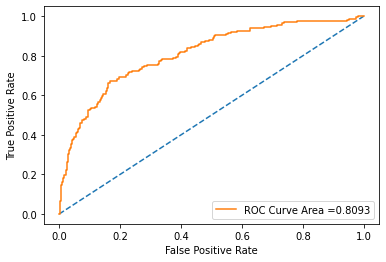

AUC= 0.8092785650373515  GM=0.7494440302900012 BL=0.36590606716244084
[0.8093]
PROMISE-ant-1 RF


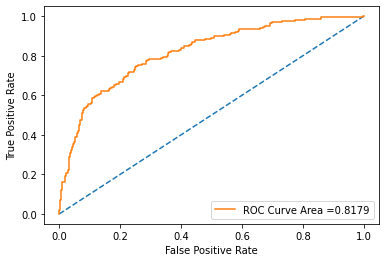

AUC= 0.8179245479326634  GM=0.7474144068491605 BL=0.3572103087534905
[0.8179]
PROMISE-ant-1 NB


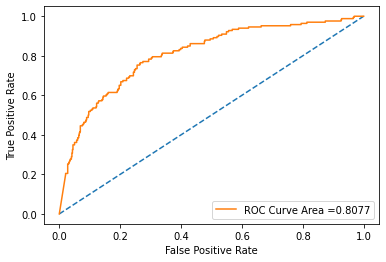

AUC= 0.8077491312399859  GM=0.749381555506539 BL=0.35488001831993493
[0.8077]
CNN Error: 23.75%
3/3 [==============================] - 0s 3ms/step
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_140 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_140 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_140 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_140 (Flatten)       (None, 108)               0         
                                                                 
 dense_280 (Dense)           (None, 21)                2289      
                                     

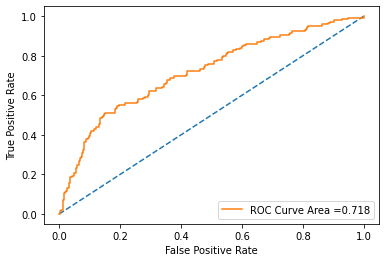

AUC= 0.7179907982734904  GM=0.666302925322924 BL=0.48898100068054845
[0.8093, 0.718]
PROMISE-camel-1 RF


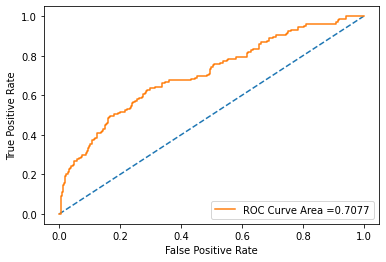

AUC= 0.7077171180572025  GM=0.6680589108328808 BL=0.4713079284370843
[0.8179, 0.7077]
PROMISE-camel-1 NB


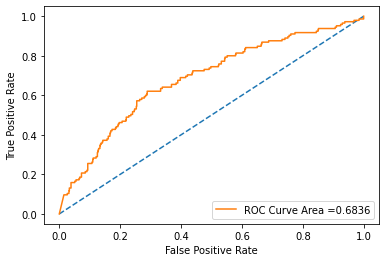

AUC= 0.6835649575487359  GM=0.6643781174728786 BL=0.4767761191661975
[0.8077, 0.6836]
CNN Error: 17.36%
3/3 [==============================] - 0s 9ms/step
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_150 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_150 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_150 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_150 (Flatten)       (None, 108)               0         
                                                                 
 dense_300 (Dense)           (None, 21)                2289      
                             

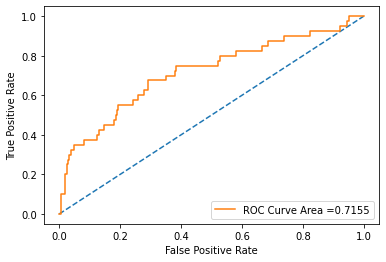

AUC= 0.7155448717948718  GM=0.6914658342969665 BL=0.43668575021913003
[0.8093, 0.718, 0.7155]
PROMISE-ivy-2 RF


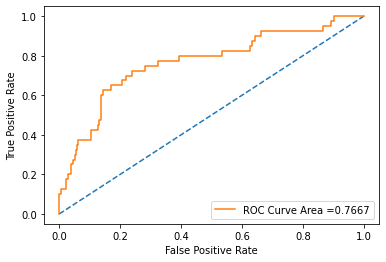

AUC= 0.7666666666666667  GM=0.7421058912622603 BL=0.36525301273721134
[0.8179, 0.7077, 0.7667]
PROMISE-ivy-2 NB


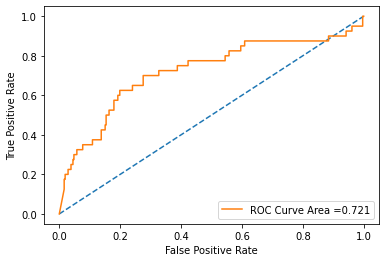

AUC= 0.7209535256410255  GM=0.7120753345337009 BL=0.40740394575462396
[0.8077, 0.6836, 0.721]
CNN Error: 15.88%
2/2 [==============================] - 0s 3ms/step
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_160 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_160 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_160 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_160 (Flatten)       (None, 108)               0         
                                                                 
 dense_320 (Dense)           (None, 21)                2289      
                     

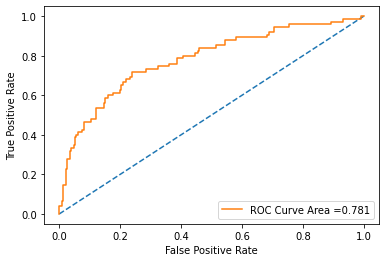

AUC= 0.781010101010101  GM=0.7406560798180412 BL=0.36754502092074126
[0.8093, 0.718, 0.7155, 0.781]
PROMISE-jedit-4 RF


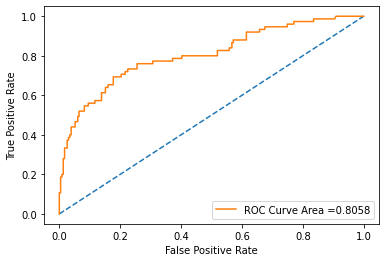

AUC= 0.8058008658008659  GM=0.7551649953978072 BL=0.3543259129251334
[0.8179, 0.7077, 0.7667, 0.8058]
PROMISE-jedit-4 NB


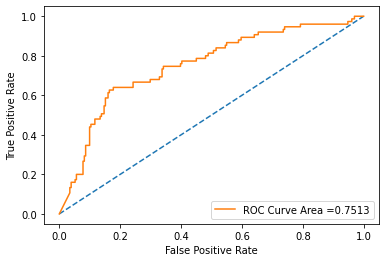

AUC= 0.7513419913419914  GM=0.725539059187668 BL=0.4013756446594446
[0.8077, 0.6836, 0.721, 0.7513]
CNN Error: 20.00%
1/1 [==============================] - 0s 27ms/step
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_170 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_170 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_170 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_170 (Flatten)       (None, 108)               0         
                                                                 
 dense_340 (Dense)           (None, 21)                2289      
              

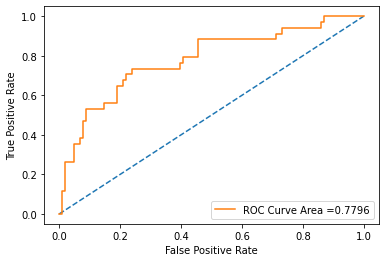

AUC= 0.779557367501456  GM=0.7487127372755514 BL=0.3557165396746232
[0.8093, 0.718, 0.7155, 0.781, 0.7796]
PROMISE-log4j-1 RF


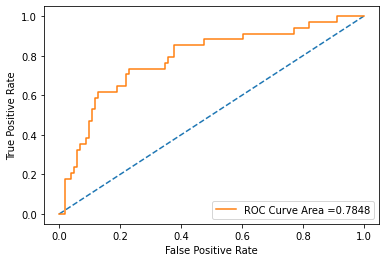

AUC= 0.7847990681421084  GM=0.7535588250012951 BL=0.34918027602640334
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848]
PROMISE-log4j-1 NB


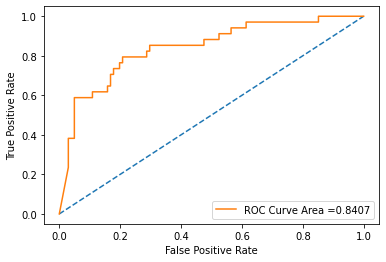

AUC= 0.8407105416423994  GM=0.7930977725843618 BL=0.2926065601305623
[0.8077, 0.6836, 0.721, 0.7513, 0.8407]
CNN Error: 20.00%
1/1 [==============================] - 0s 17ms/step
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_180 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_180 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_180 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_180 (Flatten)       (None, 108)               0         
                                                                 
 dense_360 (Dense)           (None, 21)                2289      
     

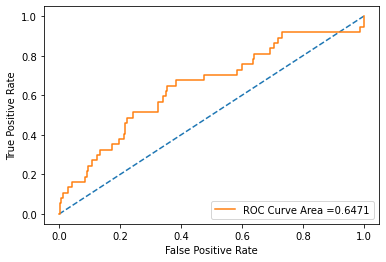

AUC= 0.6470875207337301  GM=0.6474278686893429 BL=0.49861364848113715
[0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471]
PROMISE-poi-2 RF


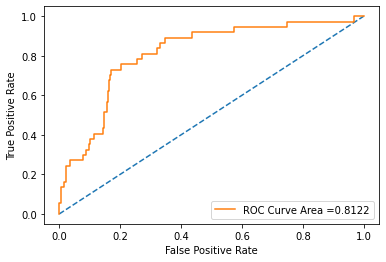

AUC= 0.8121767977363645  GM=0.7784039902118655 BL=0.31911699303582913
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122]
PROMISE-poi-2 NB


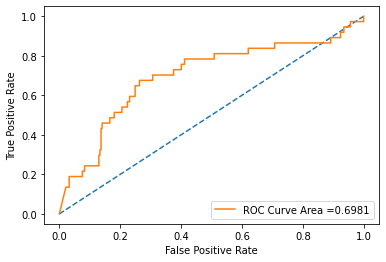

AUC= 0.6981168894526295  GM=0.7054144334221416 BL=0.41789770915811536
[0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981]
CNN Error: 40.38%
1/1 [==============================] - 0s 22ms/step
Model: "sequential_190"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_190 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_190 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_190 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_190 (Flatten)       (None, 108)               0         
                                                                 
 dense_380 (Dense)           (None, 21)                2289   

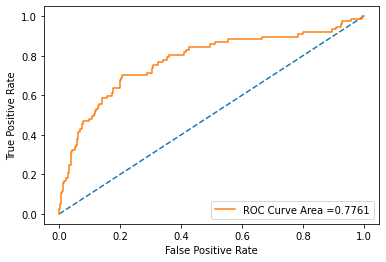

AUC= 0.776061326637511  GM=0.7461426154345233 BL=0.36293060691594153
[0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471, 0.7761]
PROMISE-tomcat RF


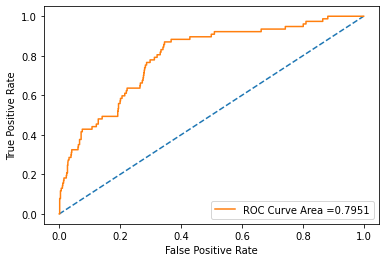

AUC= 0.7950596138816369  GM=0.7545307991110262 BL=0.36929945644465445
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122, 0.7951]
PROMISE-tomcat NB


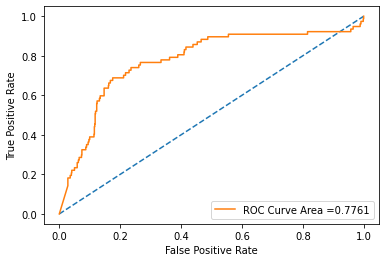

AUC= 0.776111212730931  GM=0.7533728914272286 BL=0.3576596474538795
[0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981, 0.7761]
CNN Error: 9.37%
3/3 [==============================] - 0s 2ms/step
Model: "sequential_200"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_200 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_200 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_200 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_200 (Flatten)       (None, 108)               0         
                                                                 
 dense_400 (Dense)           (None, 21)                228

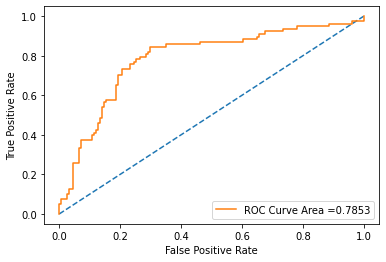

AUC= 0.7852776362710137  GM=0.7707066839364307 BL=0.33538117607942824
[0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471, 0.7761, 0.7853]
PROMISE-velocity-1 RF


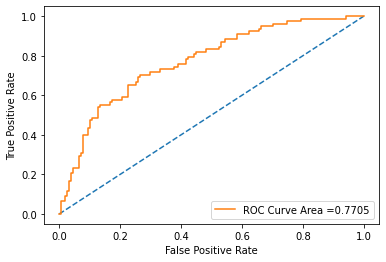

AUC= 0.770504330106979  GM=0.7199578297493697 BL=0.39638584267387705
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122, 0.7951, 0.7705]
PROMISE-velocity-1 NB


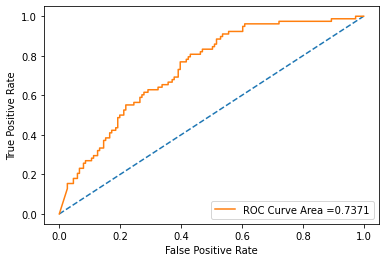

AUC= 0.7370521310918662  GM=0.6808642735086027 BL=0.4595021760643744
[0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981, 0.7761, 0.7371]
CNN Error: 30.43%
1/1 [==============================] - 0s 18ms/step
Model: "sequential_210"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_210 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_210 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_210 (Flatten)       (None, 108)               0         
                                                                 
 dense_420 (Dense)           (None, 21)        

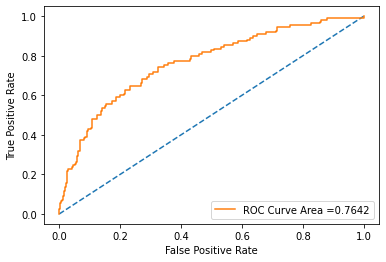

AUC= 0.7641999110188344  GM=0.7095459359803297 BL=0.41252871706472843
[0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471, 0.7761, 0.7853, 0.7642]
PROMISE-xalan-2 RF


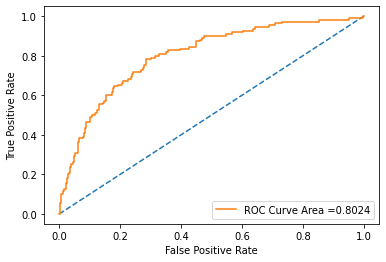

AUC= 0.8023728310840871  GM=0.7474113713151743 BL=0.3593088421752111
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122, 0.7951, 0.7705, 0.8024]
PROMISE-xalan-2 NB


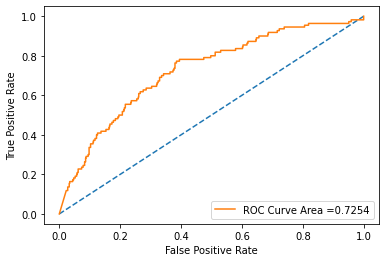

AUC= 0.7253744624054577  GM=0.6893718702992165 BL=0.44707003035457216
[0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981, 0.7761, 0.7371, 0.7254]
CNN Error: 19.44%
3/3 [==============================] - 0s 3ms/step
Model: "sequential_220"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_220 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_220 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_220 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_220 (Flatten)       (None, 108)               0         
                                                                 
 dense_440 (Dense)           (None, 21)

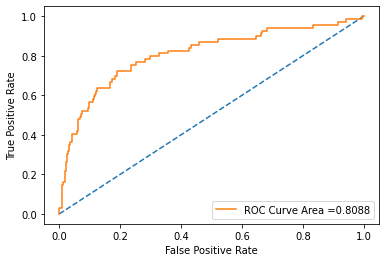

AUC= 0.8088390700483091  GM=0.7660816135682562 BL=0.33461022223071557
[0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471, 0.7761, 0.7853, 0.7642, 0.8088]
PROMISE-xerces-1 RF


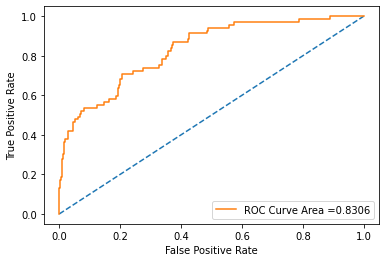

AUC= 0.8306159420289856  GM=0.751030893759799 BL=0.35544402238656
[0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122, 0.7951, 0.7705, 0.8024, 0.8306]
PROMISE-xerces-1 NB


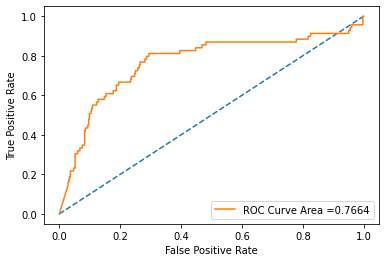

AUC= 0.7663798309178743  GM=0.7568128569752841 BL=0.34941675365117636
[0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981, 0.7761, 0.7371, 0.7254, 0.7664]
CNN Error: 23.33%
2/2 [==============================] - 0s 3ms/step
Model: "sequential_230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_230 (Conv1D)         (None, 18, 12)            60        
                                                                 
 max_pooling1d_230 (MaxPooli  (None, 9, 12)            0         
 ng1D)                                                           
                                                                 
 dropout_230 (Dropout)       (None, 9, 12)             0         
                                                                 
 flatten_230 (Flatten)       (None, 108)               0         
                                                                 
 dense_460 (Dense)           (N

In [ ]:
import warnings
warnings.filterwarnings('ignore')
all_auc = main_ImbalancedLearner()

In [ ]:
print(results)

{'AUC': {'LR': [0.8093, 0.718, 0.7155, 0.781, 0.7796, 0.6471, 0.7761, 0.7853, 0.7642, 0.8088], 'RF': [0.8179, 0.7077, 0.7667, 0.8058, 0.7848, 0.8122, 0.7951, 0.7705, 0.8024, 0.8306], 'NB': [0.8077, 0.6836, 0.721, 0.7513, 0.8407, 0.6981, 0.7761, 0.7371, 0.7254, 0.7664], 'CNN': [0.8436, 0.859, 0.8635, 0.7913, 0.8057, 0.8717, 0.9059, 0.6458, 0.8658, 0.8527]}, 'GM': {'LR': [0.7494, 0.6663, 0.6915, 0.7407, 0.7487, 0.6474, 0.7461, 0.7707, 0.7095, 0.7661], 'RF': [0.7474, 0.6681, 0.7421, 0.7552, 0.7536, 0.7784, 0.7545, 0.72, 0.7474, 0.751], 'NB': [0.7494, 0.6644, 0.7121, 0.7255, 0.7931, 0.7054, 0.7534, 0.6809, 0.6894, 0.7568], 'CNN': []}, 'BL': {'LR': [0.3659, 0.489, 0.4367, 0.3675, 0.3557, 0.4986, 0.3629, 0.3354, 0.4125, 0.3346], 'RF': [0.3572, 0.4713, 0.3653, 0.3543, 0.3492, 0.3191, 0.3693, 0.3964, 0.3593, 0.3554], 'NB': [0.3549, 0.4768, 0.4074, 0.4014, 0.2926, 0.4179, 0.3577, 0.4595, 0.4471, 0.3494], 'CNN': []}, 'LOSS': {'LR': [], 'RF': [], 'NB': [], 'CNN': [0.5485, 0.5489, 1.4779, 2.003, 0

In [ ]:
#datasets = ['data_ant-1.7','data_camel-1.6','data_ivy-2.0','data_jedit-4.3','data_log4j-1.2','data_lucene-2.4','data_pbeans2','data_poi-3.0','data_prop-6','data_synapse-1.2']
#datasets = ['AEEM-EQ', 'AEEM-JDT', 'AEEM-Lucene', 'AEEM-Mylyn', 'AEEM-PDE','JIRA-activemq-5', 'JIRA-derby-10', 'JIRA-hbase-0','JIRA-groovy-1_6_BETA_1', 'JIRA-hive-0', 'JIRA-jruby-1', 'JIRA-wicket-1','PROMISE-ant-1', 'PROMISE-camel-1', 'PROMISE-ivy-2', 'PROMISE-jedit-4', 'PROMISE-log4j-1', 'PROMISE-poi-2', 'PROMISE-tomcat', 'PROMISE-velocity-1', 'PROMISE-xalan-2', 'PROMISE-xerces-1']
#datasets = ['AEEM-EQ', 'AEEM-JDT', 'AEEM-Lucene', 'AEEM-Mylyn', 'AEEM-PDE']
#datasets = ['JIRA-activemq-5', 'JIRA-derby-10', 'JIRA-hbase-0','JIRA-groovy-1_6_BETA_1', 'JIRA-hive-0', 'JIRA-jruby-1', 'JIRA-wicket-1']
datasets = ['PROMISE-ant-1', 'PROMISE-camel-1', 'PROMISE-ivy-2', 'PROMISE-jedit-4', 'PROMISE-log4j-1', 'PROMISE-poi-2', 'PROMISE-tomcat', 'PROMISE-velocity-1', 'PROMISE-xalan-2', 'PROMISE-xerces-1']
df = pd.DataFrame(results['AUC'],index=datasets)
df.to_csv('auc.csv')

In [ ]:
print(df)

                        LR      RF      NB     CNN
PROMISE-ant-1       0.8093  0.8179  0.8077  0.8436
PROMISE-camel-1     0.7180  0.7077  0.6836  0.8590
PROMISE-ivy-2       0.7155  0.7667  0.7210  0.8635
PROMISE-jedit-4     0.7810  0.8058  0.7513  0.7913
PROMISE-log4j-1     0.7796  0.7848  0.8407  0.8057
PROMISE-poi-2       0.6471  0.8122  0.6981  0.8717
PROMISE-tomcat      0.7761  0.7951  0.7761  0.9059
PROMISE-velocity-1  0.7853  0.7705  0.7371  0.6458
PROMISE-xalan-2     0.7642  0.8024  0.7254  0.8658
PROMISE-xerces-1    0.8088  0.8306  0.7664  0.8527


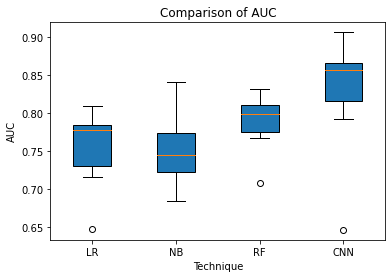

In [ ]:
import seaborn as sns
#sns.boxplot(df)

alldata=[df['LR'],df['NB'],df['RF'],df['CNN']]
pyplot.boxplot(alldata,patch_artist=True, labels=['LR','NB','RF','CNN'])
pyplot.title("Comparison of AUC")
pyplot.xlabel("Technique")
pyplot.ylabel("AUC")
pyplot.show()

In [ ]:
df = pd.DataFrame(results['AUC'], index=datasets)
df.to_csv('auc.csv')




df = pd.DataFrame(results['RECALL'], index=datasets)
df.to_csv('recall.csv')

df = pd.DataFrame(results['F1'], index=datasets)
df.to_csv('f1.csv')

df = pd.DataFrame(results['PRECISION'], index=datasets)
df.to_csv('precision.csv')

df = pd.DataFrame(results['MCC'], index=datasets)
df.to_csv('mcc.csv')